# S-1 Tall Rocket

TODO: We need to update these links   
[Project page](https://insert_link)   
[Design Doc](https://insert_link)  
[Google Drive](https://insert_link)  
[OnShape](https://insert_link)  
[Github](https://insert_link)  
[YouTube](https://insert_link)  
[Simulation](https://insert_link)

![](img/full_horz_opaque_line_view.png)

## Setup

In [1]:
# imports
import math
import random
import pint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# math
pi = math.pi

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def magnitude(v):
    # Pythagoras' theorem generalized to any number of dimensions
    return (v**2).sum()**0.5

# engineering
# `pint` handles automatic unit conversion and scaling
u = pint.UnitRegistry()
s = u.second
kg = u.kilogram
g = u.gram
L = u.liter
km = u.kilometer
m = u.meter
cm = u.centimeter
mm = u.millimeter
ft = u.foot
inch = u.inch
atm = u.atmosphere
Pa = u.pascal
K = u.kelvin
J = u.joule
mol = u.mole
deg = u.degree
rad = u.radian

# plotting
sns.set_style('whitegrid')

## Design

This section describes the design of the S-1 rocket using a mixture of code and natural language. Writing in code saves having to re-enter the same information into the simulator and makes exploring parameters easier.

In [9]:
class DragSurface:
  # frontal drag
  front_area: float
  front_drag_coefficient: float 
  # used for wave drag
  side_area: float
  length: float # up-down length
  thickness: float
  sweep_angle: float
  airfoil_technology_factor: float

  def __init__(self, front_area, front_drag_coefficient, side_area, length, thickness, sweep_angle, airfoil_technology_factor):
    self.front_area = front_area
    self.front_drag_coefficient = front_drag_coefficient
    self.side_area = side_area
    self.length = length
    self.thickness = thickness
    self.sweep_angle = sweep_angle
    self.airfoil_technology_factor = airfoil_technology_factor

In [8]:
class Params:

  # geomety parameters
  class Body:
    LENGTH = 188.5*inch  # base to nose length
    WIDTH = 6*inch  # apothem length
    WINGSPAN = 17.875*inch  # widest separation between wingtips
    DRAG_COEFFICIENT = 0.1
    NOSE_SWEEP_ANGLE = 25*deg

  class Fins:
    NUM = 4
    THICKNESS = 0.125*inch
    MAX_WIDTH = 3.0*inch # TODO: insert actual value
    LENGTH = 7.5*inch # TODO: insert actual value
    SWEEP = 15*deg # TODO: insert actual value

  # TODO: check these parameters
  # areodynamic parameters
  body_drag_surface = DragSurface(
    front_area=Body.WIDTH**2,
    front_drag_coefficient=0.1,
    side_area=4*Body.WIDTH*Body.LENGTH,
    length=Body.LENGTH,
    thickness=Body.WIDTH,
    sweep_angle=Body.NOSE_SWEEP_ANGLE,
    airfoil_technology_factor=0.9
  )
  fin_drag_surface = DragSurface(
    front_area=Fins.THICKNESS*Fins.MAX_WIDTH,
    front_drag_coefficient=0.1,
    side_area=4*Fins.THICKNESS*Fins.LENGTH,
    length=Fins.LENGTH,
    thickness=Fins.THICKNESS,
    sweep_angle=Fins.SWEEP,
    airfoil_technology_factor=0.9
  )
  drag_surfaces = [body_drag_surface] + Fins.NUM * [fin_drag_surface]
  
  # fuel parameters
  class Oxidizer:
    tank_volume = 10 * L
    concentration = 0.68 # 68% Nitric Acid, 32% of Water
    density = 1.410*kg/L
    # you can flip this around and use the mass to calculate the volume
    mass = 12.0*kg
    volume = mass / density
    assert volume <= tank_volume, "Initial oxidizer volume does not fit in tank"
  class Reducer:
    tank_volume = 10 * L
    # what is the reducer?
    density = 0.800*kg/L
    # you can flip this around and use the mass to calculate the volume
    mass = 12.0*kg
    volume = mass / density
    assert volume <= tank_volume, "Initial reducer volume does not fit in tank"
  # the ideal mixture ratio is 7.05:1 by mass or 4:1 by volume (oxidizer:reducer)
  # however, the true ratio is determined by tank pressures, fuel masses, and fluid dynamics
  # and should be simulated rather than assumed

  # mass parameters
  # TODO: separate some of these params into the fuel-specific classe and calculate upper and lower limits on mass
  DRY_MASS = 18*kg
  INITIAL_PROP_MASS = Oxidizer.mass + Reducer.mass
  WET_MASS = DRY_MASS + INITIAL_PROP_MASS
  TOTAL_MASS_RATIO = WET_MASS / DRY_MASS

  # propulsion parameters
  class Engine:
    contraction_ratio = 1.0
    exhaust_pressure = 1.0*atm
    max_temp = 2149*K

  # motion variables
  SEA_LEVEL = 6,371.001*km  # average sea level. https://en.wikipedia.org/wiki/Sea_level#:~:text=It%20is%206%2C356.752%20km%20(3%2C949.903,(3%2C958.756%20mi)%20on%20average.
  GROUND_ELEVATION_FROM_SEA_LEVEL = 367*ft  # Midlothian, TX. https://www.google.com/search?q=midlothian+altitude+above+sea+level&oq=midlothian+altitude+above+se&aqs=chrome.1.69i57j33i160.5307j0j7&sourceid=chrome&ie=UTF-8
  GROUND_LEVEL = SEA_LEVEL + GROUND_ELEVATION_FROM_SEA_LEVEL
  pos = np.array([0, 0, GROUND_LEVEL])*m
  vel = np.array([0, 0, 0])*m/s
  orientation = np.array([0, 0, 0])*deg # global frame
  angular_vel = np.array([0, 0, 0])*rad/s # local frame

  seed = random.randint() # keeps random values from being the same every time

AssertionError: Initial reducer volume does not fit in tank

Now you can initialize a copy of the parameters without changing the original ones like so:

In [10]:
params = Params()
params.WET_MASS = 5*kg
print('The `params` wet mass has been changed:', params.WET_MASS)
print('But the oringonal `Params` wet mass is still:', Params.WET_MASS)

The `rocket` wet mass has been changed: 5 kilogram
But the oringonal `S1_Tall` wet mass is still: 42 kilogram


I'm not sure how what these numbers mean
  
0.0247111043088 m^3  
31.8279023497 kg of prop if 0% ullage  
23.8709267623 kg of prop with 25% ullage  
10 kg tank  
0.511923525887 kg/s mass flow  
3 inch diameter combustion chamber  
1 inch diameter throat (15 degree)  
3 inch diameter nozzle (15 degree)  
6 in long chamber  
ISP 169.54, 200.54  
VEX 1662.60, 1966.63  
At burnout which is 50 psi, mass flow 0.127980881472  
ISP 87.21, 197.65  
VEX 855.20, 1938.30

Tank pressure -> mas flow -> ISP -> VEX

## Simulation

This section contains code to simulate the S-1-Tall rocket's trajectory and state during flight.

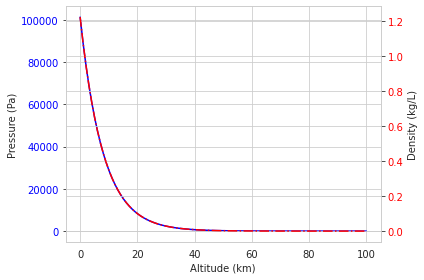

In [16]:
def atmospheric_change_factor(altitude):
  altitude = max(altitude, 0)  # ignore negative altitudes
  # I assume the standard temperature lapse rate equals zero
  # https://en.wikipedia.org/wiki/Barometric_formula
  return math.exp(
    ((-9.80665*m/s**2) * (0.0289644*kg/mol) * altitude) /
    ((8.3144598*J/(mol*K)) * (273*K)))

def pressure_at_altitude(altitude):
  # https://en.wikipedia.org/wiki/Barometric_formula#Pressure_equations
  # P(h) = P0 * exp(-g * M * h / (R*T))
  return 101325*Pa * atmospheric_change_factor(altitude)

def density_at_altitude(altitude):
  # https://en.wikipedia.org/wiki/Barometric_formula#Density_equations
  # p(h) = p0 * exp(-g * M * h / (R*T))
  return 1.225*kg/L * atmospheric_change_factor(altitude)

def speed_of_sound_at_altitude(altitude):
  # c(h) = c0 * sqrt(1 + g * M * h / (R*T))
  # TODO: what is the actual formula?
  return 343*m/s

def drag_coefficient_at_altitude(
  normal_drag_coefficient, altitude, orientation, velocity, wind_speed,
  sweep_angle, length, thickness, airfoil_technology_factor=0.8):
  # I couldn't find a good reference for what an airfoil technology factor is
  # some values are 0.87 and 0.95: http://www.dept.aoe.vt.edu/~mason/Mason_f/ConfigAeroTransonics.pdf
  # so I felt 0.8 makes a reasonable assumption

  speed_of_sound = speed_of_sound_at_altitude(altitude)
  relative_velocity = velocity - wind_speed
  mach_number = magnitude(relative_velocity) / speed_of_sound

  # thickness-chord ratio, also known as relative thickness. https://en.wikipedia.org/wiki/Thickness-to-chord_ratio
  thickness_chord_ratio = thickness / length
  
  # https://aviation.stackexchange.com/questions/55169/how-can-one-approximately-guesstimate-wave-drag
  # Drag Divergence Mach number: Mach number where "wave drag c_d_w starts becoming relevant"
  drag_divergence_mach_number = \
    (airfoil_technology_factor / math.cos(sweep_angle.to(rad).magnitude)) + \
    (thickness_chord_ratio / (math.cos(sweep_angle.to(rad).magnitude))**2)
  # Mach critical number: "the [Mach] number at which the flow becomes locally supersonic"
  mach_critical_number = drag_divergence_mach_number - (0.1/80)**(1/3)
  # wave drag coefficient: 
  #   "component of the aerodynamic drag [...] projectiles moving at 
  #   transonic and supersonic speeds, due to the presence of shock waves"
  #   https://en.wikipedia.org/wiki/Wave_drag
  # Following forumla from: https://aviation.stackexchange.com/questions/55169/how-can-one-approximately-guesstimate-wave-drag
  wave_drag_coefficient = 20 * (mach_number - mach_critical_number)**4

  # normal drag coefficient:


# test formulas for altitude range from 0km to 100km
altitudes = np.linspace(0, 100*km, 100)
pressures = [pressure_at_altitude(altitude) for altitude in altitudes]
densities = [density_at_altitude(altitude) for altitude in altitudes]

# convert to unitless floats
altitudes = [altitude.to(km).magnitude for altitude in altitudes]
pressures = [pressure.to(Pa).magnitude for pressure in pressures]
densities = [density.to(kg/L).magnitude for density in densities]

# plot results
## pressure
fig, ax1 = plt.subplots()
ax1.set_xlabel('Altitude (km)')
ax1.set_ylabel('Pressure (Pa)')
ax1.plot(altitudes, pressures, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
## density
ax2 = ax1.twinx()
ax2.set_ylabel('Density (kg/L)')
ax2.plot(altitudes, densities, color='red', linestyle='-.')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()

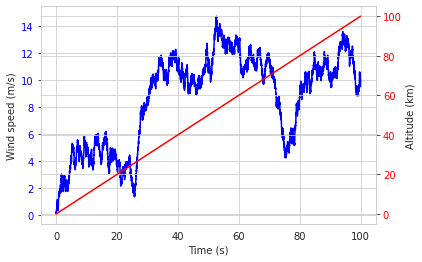

In [44]:
class WindModel:
  def simulate_velocity(self): ...

class BrownianWindModel(WindModel):
  def simulate_velocity(self): ...

class JacobsWindModel(WindModel):
  fluctuation_rate=1.0/s
  typical_horizontal_wind_speed = 10*m/s
  typical_vertical_wind_speed = 0*m/s

  _prev_wind_vel = np.array([0, 0, 0])*m/s
  def simulate_velocity(self, altitude, dt): 

    # get xy and z components of the wind
    prev_horizontal_wind_speed = magnitude(prev_wind_vel[0:2])
    prev_vertical_wind_speed = prev_wind_vel[2]
    # random fluctuation generally in same direction as previous wind
    random_wind_vel = np.random.normal(
      loc=prev_wind_vel.to(m/s).magnitude,
      scale=[
        typical_horizontal_wind_speed.to(m/s).magnitude,
        typical_horizontal_wind_speed.to(m/s).magnitude,
        typical_vertical_wind_speed.to(m/s).magnitude,
      ]
    ) * m/s

    # calculate the effect of this fluctuation on the wind speed
    beta = fluctuation_rate * dt
    assert 0 < beta < 1, f'`fluctuation_impact_per_second * dt` must be between 0 and 1 but is: {beta}'
    new_wind_vel = beta*random_wind_vel + (1-beta)*prev_wind_vel
    
    return new_wind_vel

# simulate wind along a trajectory

## generate input data
duration = 100*s
dt = 1e-2*s
steps = int(duration/dt)
Ts = np.linspace(0, duration, steps)
Xs = np.linspace(0, 0, steps)
Ys = np.linspace(0, 0, steps)
Zs = np.linspace(0, 100*km, steps)

## simulate wind
prev_wind_vel = np.array([0, 0, 0])*m/s
wind_vels = []
for step, t in enumerate(Ts):
  wind_vel = estimate_wind_velocity(
    altitude=Zs[step], prev_wind_vel=prev_wind_vel, dt=dt,
    fluctuation_rate=1.0/s)
  wind_vels.append(wind_vel)
  prev_wind_vel = wind_vel
wind_speeds = [
  magnitude(wind_vel.to(m/s).magnitude)
  for wind_vel in wind_vels]

## plot results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Wind speed (m/s)')
ax1.plot(Ts, wind_speeds, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Altitude (km)')
ax2.plot(Ts, Zs, color='red')
ax2.tick_params(axis='y', labelcolor='red')

In [ ]:
def step(params: Params) -> Params:
  # controller output (decisions)
  ## TODO: should we deploy the parachute?
  ## TODO: should we abort?

  # calculate combustion variables
  def isp(oxidizer_pressure, reducer_pressure, ambient_pressure):
    return # TODO

  # calculate propulsion variables

  # calculate atmospheric variables
  # TODO: pressure, density, air_viscosity, air_speed_of_sound, etc
  ## frontal drag
  # TODO
  ## skin drag
  # TODO
  # https://en.wikipedia.org/wiki/Skin_friction_drag#Skin_friction_drag
  # wind
  calculate_wind

  # update trajectory variables

In [ ]:
params = DEFAULTS()

while not done:
  # update
  params = step(params)

  # save params

## Performance

This section will analyze the actual data collected for the rocket.